In [130]:
import os
import os.path

import math

import pandas as pd

import numpy as np

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute
import sklearn.compose
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

import seaborn as sns

import geopy.geocoders
import geopy.extra.rate_limiter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [92]:
df = pd.read_csv(os.path.join(os.getcwd(), 'NH_ProviderInfo_Jan2022.csv'))
df.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Total number of nurse staff hours per resident per day on the weekend,Registered Nurse hours per resident per day on the weekend,Reported Physical Therapist Staffing Hours per Resident Per Day,Total nursing staff turnover,Total nursing staff turnover footnote,Registered Nurse turnover,Registered Nurse turnover footnote,Number of administrators who have left the nursing home,Administrator turnover footnote,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
0,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Corporation,57,53.2,NaN,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",9/1/1969,N,NaN,N,Y,N,Both,Yes,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,1.0,12.0,1.0,12.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8/21/2019,2,2,0,8,1,0,8,8/1/2018,1,1,0,4,1,0,4,6/22/2017,0,0,0,0,0,0,0,5.333,0,0,0.0,1,650.0,0,1,"701 MONROE STREET NW,RUSSELLVILLE,AL,356

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15238 entries, 0 to 15237
Data columns (total 96 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Federal Provider Number                                                15238 non-null  object 
 1   Provider Name                                                          15238 non-null  object 
 2   Provider Address                                                       15238 non-null  object 
 3   Provider City                                                          15238 non-null  object 
 4   Provider State                                                         15238 non-null  object 
 5   Provider Zip Code                                                      15238 non-null  int64  
 6   Provider Phone Number                                                  15238 non-null 

In [94]:
cat_cols = ['Provider City',
            'Provider State',
            'Provider Zip Code',
            'Provider SSA County Code',
            'Ownership Type',
            'Provider Type',
            'Provider Resides in Hospital',
            'Continuing Care Retirement Community',
            'Special Focus Status',
            'Abuse Icon',
            'Most Recent Health Inspection More Than 2 Years Ago',
            'Provider Changed Ownership in Last 12 Months',
            'With a Resident and Family Council',
            'Automatic Sprinkler Systems in All Required Areas',
            'Long-Stay QM Rating Footnote',
            'Short-Stay QM Rating Footnote',
            'Staffing Rating Footnote',
            'RN Staffing Rating Footnote',
            'Reported Staffing Footnote',
            'Physical Therapist Staffing Footnote',
            'Total nursing staff turnover footnote',
            'Registered Nurse turnover footnote',
            'Administrator turnover footnote']

num_cols = ['Number of Certified Beds',
            'Average Number of Residents per Day',
            'Overall Rating',
            'Health Inspection Rating',
            'QM Rating',
            'Long-Stay QM Rating',
            'Short-Stay QM Rating',
            'Staffing Rating',
            'RN Staffing Rating',
            'Reported Nurse Aide Staffing Hours per Resident per Day',
            'Reported LPN Staffing Hours per Resident per Day',
            'Reported RN Staffing Hours per Resident per Day',
            'Reported Licensed Staffing Hours per Resident per Day',
            'Reported Total Nurse Staffing Hours per Resident per Day',
            'Total number of nurse staff hours per resident per day on the weekend',
            'Registered Nurse hours per resident per day on the weekend',
            'Reported Physical Therapist Staffing Hours per Resident Per Day',
            'Total nursing staff turnover',
            'Registered Nurse turnover',
            'Number of administrators who have left the nursing home',
            'Case-Mix Nurse Aide Staffing Hours per Resident per Day',
            'Case-Mix LPN Staffing Hours per Resident per Day',
            'Case-Mix RN Staffing Hours per Resident per Day',
            'Case-Mix Total Nurse Staffing Hours per Resident per Day',
            'Adjusted Nurse Aide Staffing Hours per Resident per Day',
            'Adjusted LPN Staffing Hours per Resident per Day',
            'Adjusted RN Staffing Hours per Resident per Day',
            'Adjusted Total Nurse Staffing Hours per Resident per Day',
            'Rating Cycle 1 Total Number of Health Deficiencies',
            'Rating Cycle 1 Number of Standard Health Deficiencies',
            'Rating Cycle 1 Number of Complaint Health Deficiencies',
            'Rating Cycle 1 Health Deficiency Score',
            'Rating Cycle 1 Number of Health Revisits',
            'Rating Cycle 1 Health Revisit Score',
            'Rating Cycle 1 Total Health Score',
            'Rating Cycle 2 Total Number of Health Deficiencies',
            'Rating Cycle 2 Number of Standard Health Deficiencies',
            'Rating Cycle 2 Number of Complaint Health Deficiencies',
            'Rating Cycle 2 Health Deficiency Score',
            'Rating Cycle 2 Number of Health Revisits',
            'Rating Cycle 2 Health Revisit Score',
            'Rating Cycle 2 Total Health Score',
            'Rating Cycle 3 Total Number of Health Deficiencies',
            'Rating Cycle 3 Number of Standard Health Deficiencies',
            'Rating Cycle 3 Number of Complaint Health Deficiencies',
            'Rating Cycle 3 Health Deficiency Score',
            'Rating Cycle 3 Number of Health Revisits',
            'Rating Cycle 3 Health Revisit Score',
            'Rating Cycle 3 Total Health Score',
            'Total Weighted Health Survey Score',
            'Number of Facility Reported Incidents',
            'Number of Substantiated Complaints',
            'Number of Citations from Infection Control Inspections']

target_column = 'Total Amount of Fines in Dollars'

d:\Development\cs6340-final-project\.env\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


<AxesSubplot:ylabel='Count'>

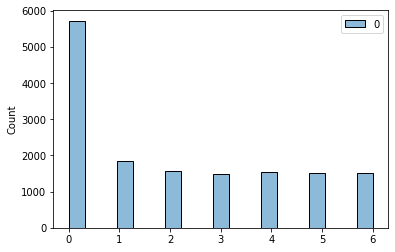

In [95]:
binner = sklearn.compose.ColumnTransformer([
    ("kbins", sklearn.preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'), [target_column])
])

bins = binner.fit_transform(df)
sns.histplot(bins)

In [96]:
categorical_pipeline = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.OneHotEncoder()
)

numeric_pipeline = sklearn.pipeline.make_pipeline(
    sklearn.impute.SimpleImputer(strategy='median'),
    sklearn.preprocessing.StandardScaler()
)

full_pipeline = sklearn.compose.ColumnTransformer([
    ("categorical", categorical_pipeline, cat_cols),
    ("numeric", numeric_pipeline, num_cols)
])

In [97]:
features_matrix = full_pipeline.fit_transform(df)
features_matrix.shape

(15238, 14847)

In [98]:
training_features, testing_features, training_targets, testing_targets = sklearn.model_selection.train_test_split(features_matrix, df[target_column], test_size=0.25, stratify=bins)

In [99]:
model = sklearn.linear_model.SGDRegressor()
model.fit(training_features, training_targets)

SGDRegressor()

In [100]:
predictions = model.predict(testing_features)

In [101]:
error = math.sqrt(sklearn.metrics.mean_squared_error(testing_targets, predictions))
error

49603.932986343294

In [110]:
df['Full Address'] = df['Provider Address'] + ", " + df['Provider City'] + ", " + df['Provider State'] + " " + df['Provider Zip Code'].astype(str)
df.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Total number of nurse staff hours per resident per day on the weekend,Registered Nurse hours per resident per day on the weekend,Reported Physical Therapist Staffing Hours per Resident Per Day,Total nursing staff turnover,Total nursing staff turnover footnote,Registered Nurse turnover,Registered Nurse turnover footnote,Number of administrators who have left the nursing home,Administrator turnover footnote,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date,Full Address
0,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Corporation,57,53.2,NaN,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",9/1/1969,N,NaN,N,Y,N,Both,Yes,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,1.0,12.0,1.0,12.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8/21/2019,2,2,0,8,1,0,8,8/1/2018,1,1,0,4,1,0,4,6/22/2017,0,0,0,0,0,0,0,5.333,0,0,0.0,1,650.0,0,1,"701 MONROE STREET NW,RUSSEL

In [114]:
address = df.iloc[0]['Location']

In [157]:
geolocator = geopy.geocoders.Nominatim(user_agent='jacks-ml-project')
geocode_rate_limited = geopy.extra.rate_limiter.RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [158]:
df['geo_loc'] = df['Full Address'].apply(geocode_rate_limited)
df['geo_point'] = df['geo_loc'].apply(lambda x: tuple(x.point)[0:2] if x else (np.nan, np.nan))
df[['lat', 'lon']] = pd.DataFrame(df['geo_point'].tolist(), index=df.index)
df = df.drop(columns=['geo_loc', 'geo_point'])

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2625 MAPLE AVE., LOS ANGELES, CA 90011',), **{}).
Traceback (most recent call last):
  File "d:\Development\cs6340-final-project\.env\lib\site-packages\geopy\adapters.py", line 297, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "c:\python38\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "c:\python38\lib\urllib\request.py", line 542, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "c:\python38\lib\urllib\request.py", line 502, in _call_chain
    result = func(*args)
  File "c:\python38\lib\urllib\request.py", line 1393, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "c:\python38\lib\urllib\request.py", line 1354, in do_open
    r = h.getresponse()
  File "c:\python38\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "c:\python38\lib\http\client.py", line 307, in begin
   

In [160]:
df.head()
df.to_csv('NH_ProviderInfo_Jan2022_with_coords.csv')